This code opens pmaps from files and uses ipywidgets to do some basic interpretation on the Daly River data set.

TODO in 2020 add interpretation tool

Neil Symington
neil.symington@ga.gov.au

In [2]:
#%matplotlib inline#%matplotlib widget

UsageError: unrecognized arguments: widget


In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
import aseg_gdf2
from shapely.geometry import Point
from shapely.wkt import loads
from scipy.io import loadmat
from scipy import spatial
import matplotlib.pyplot as plt
import rasterio
import netCDF4
import os

In [3]:
# Function for finding the nearest point from geopandas frame
def find_nearest_point_ind(gdf, pt):
    
    dist = gdf.distance(pt)
    # retrun the nearest index and the distance
    return dist.idxmin(), dist.min()

def extract_pmap_info(D, near_fid):
    """
    @param: D: python dictionary from loadmat function in scipy
    
    returns
    a more usebal dictionary
    """

    freq = D['M']['f'][0,0]


    pdf = freq / freq.sum(axis =1)[0]

    pdf[pdf == 0] = np.nan

    # Get the changepoint histogram

    cp = D['M']['cp'][0,0].flatten()

    cp_pdf = D['M']['cp'][0,0] / freq.sum(axis =1)[0]

    # Get the extent

    extent = [D['M']['vmin'][0,0][0,0], D['M']['vmax'][0,0][0,0], D['M']['pmax'][0,0][0,0], D['M']['pmin'][0,0][0,0]]

    # Get the information from the datafile

    p10 = near_fid[[x for x in gdf_AEM.columns if x.startswith('conductivity_p10')]].astype(np.float).values
    p50 = near_fid[[x for x in gdf_AEM.columns if x.startswith('conductivity_p50')]].astype(np.float).values
    p90 = near_fid[[x for x in gdf_AEM.columns if x.startswith('conductivity_p90')]].astype(np.float).values
    mean = near_fid[[x for x in gdf_AEM.columns if x.startswith('conductivity_mean')]].astype(np.float).values
    depth_cells = near_fid[[x for x in gdf_AEM.columns if x.startswith('depth')]].astype(np.float).values

    cond_cells = np.linspace(D['M']['vmin'][0,0][0,0], D['M']['vmax'][0,0][0,0], D['M']['nvcells'][0,0][0,0])
    
    
    laybins = D['M']['lhist'][0,0][0,0][1].flatten()
    lay_pob = D['M']['lhist'][0,0][0,0][2].flatten() / freq.sum(axis =1)[0]

    nsample = D['M']['nsample'][0,0][0,0]

    ndata = int(D['M']['ndata'][0,0][0,0])
    nsamples = np.int(D['M']['nsample'][0,0][0,0])
    nchains = np.int(D['M']['nchain'][0,0][0,0])
    burnin = int(D['M']['nburnin'][0,0][0,0])
    
    misfit = {}
    sample_no = {}
    
    for i in range(nchains):
        misfit[i] = D['M']['conv'][0,0]['misfit'][0,i].flatten()
        sample_no[i] = D['M']['conv'][0,0]['sample'][0,i].flatten()
        
    
    return {'conductivity_pdf': pdf, "change_point_pdf": cp_pdf, "conductivity_extent": extent,
           'cond_p10': p10, 'cond_p50': p50, 'cond_p90': p90, 'cond_mean': mean, 'depth_cells': depth_cells,
           'nlayer_bins': laybins, 'nlayer_prob': lay_pob, 'nsamples': nsample, 'ndata': ndata,
           "nchains": nchains, 'burnin': burnin, 'misfit': misfit, 'sample_no': sample_no, 'cond_cells': cond_cells}

def extract_data(near_fid):
    

    infile = near_fid['matfile']

    D = extract_pmap_info(loadmat(infile), near_fid)
    
    D['easting'] = near_fid['easting ']
    D['northing'] =  near_fid['northing ']
    D['fid'] = near_fid['fiducial ']
    
    # Get point elevation from grid
    point_elev = next(dataset.sample([[D['easting'],D['northing']]]))[0]

    # Spatial query to find nearest fiducial

    lci_coords = np.column_stack((lci_dat['easting'][:],
                                 lci_dat['northing'][:]))

    tree = spatial.KDTree(lci_coords.data)

    dist, ind = tree.query([D['easting'], D['northing']])

    D['elevation'] = lci_dat['elevation'][ind]

    D['lci_cond'] = lci_dat['conductivity'][ind]
    D['lci_depth_top'] = lci_dat['layer_top_depth'][ind]

    D['lci_doi'] = lci_dat['depth_of_investigation'][ind]

    D['line'] = near_fid['line ']

    D['Oooloo_contact_depth'] = D['elevation'] - point_elev
    
    if D['Oooloo_contact_depth'] < 0:
        D['Oooloo_contact_depth'] = 0
    
    return D

def Daly_plot(D, outfile = None):
    fig = plt.figure(figsize = (12,10))

    #fig.canvas.layout.width = '12in'
    #fig.canvas.layout.height= '8in'

    ax1 = fig.add_axes([0.05, 0.2, 0.35, 0.7])
    ax2 = fig.add_axes([0.45, 0.2, 0.2, 0.7])
    ax3 = fig.add_axes([0.72, 0.2, 0.2, 0.35])
    ax4 = fig.add_axes([0.72, 0.6, 0.2, 0.3])
    cbar_ax = fig.add_axes([0.05, 0.1, 0.35, 0.02])


    # Plot probability map
    im = ax1.imshow(D['conductivity_pdf'], extent = D['conductivity_extent'],
                    aspect = 'auto', cmap = 'rainbow')
    #  PLot the median, and percentile plots
    ax1.plot(np.log10(D['cond_p10']), D['depth_cells'], c = 'k',linestyle='dashed', label = 'p10')
    ax1.plot(np.log10(D['cond_p90']), D['depth_cells'], c = 'k',linestyle='dashed', label = 'p90')
    ax1.plot(np.log10(D['cond_p50']), D['depth_cells'], c = 'k',label = 'p50')
    ax1.plot(np.log10(D['cond_mean']), D['depth_cells'], c = 'grey',label = 'mean')

    # for lci layered model we do some processing
    lci_expanded = np.zeros(shape=2 * len(D['lci_cond']) + 1,
                                 dtype=np.float)

    lci_expanded[1:] = np.repeat(D['lci_cond'], 2)

    depth_expanded = (np.max(D['lci_depth_top']) + 10) * np.ones(shape=len(lci_expanded),
                                                            dtype=np.float)

    depth_expanded[:-1] = np.repeat(D['lci_depth_top'], 2)

    ax1.plot(np.log10(lci_expanded), depth_expanded, c = 'pink',
             linestyle = 'dashed', label = 'lci')
    ax1.plot(ax1.get_xlim(), [D['lci_doi'], D['lci_doi']], c = 'pink',
             label = 'LCI doi')
    ax1.plot(ax1.get_xlim(), [D['Oooloo_contact_depth'], D['Oooloo_contact_depth']], c = 'red',
             label = 'Mapped contact', linestyle = 'dashed')
    ax1.set_title('probability map')
    ax1.set_ylabel('depth (mBGL)')
    ax1.set_xlabel('log10 conductivity (S/m)')
    ax1.grid(which = 'both')
    ax1.set_xlim(D['conductivity_extent'][0], D['conductivity_extent'][1])
    ax1.set_ylim(D['conductivity_extent'][2], D['conductivity_extent'][3])
    ax1.legend()

    ax2.plot(D['change_point_pdf'], D['depth_cells'], label = 'P(change point)')
    ax2.set_ylim(ax2.get_ylim()[::-1])
    ax2.set_yticks(np.arange(0, 500, 20.))
    ax2.set_title('change point probability')
    ax2.set_ylim(D['conductivity_extent'][2], D['conductivity_extent'][3])
    ax2.plot(ax2.get_xlim(), [D['Oooloo_contact_depth'], D['Oooloo_contact_depth']], c = 'red',
             label = 'Mapped contact', linestyle = 'dashed')
    ax2.legend()
    ax2.grid(which = 'both')

    #ax3.bar(D['nlayer_bins'], height = D['nlayer_prob'])
    #ax3.set_xlabel ("no of layers")
    ax3.imshow(contact_elev, extent = [dataset.bounds[0], dataset.bounds[2],
                                     dataset.bounds[1], dataset.bounds[3]])
    ax3.plot(D['easting'],D['northing'], 'ro')
    # Ax3 will be our location

    for item in D['misfit'].keys():
        sample = D['sample_no'][item]
        misfits = D['misfit'][item]
        ax4.plot(sample, misfits/D['ndata'])

    ax4.plot([1, D['nsamples']], [1,1], 'k')
    ax4.plot([D['burnin'], D['burnin']],[0.1,1e4], 'k')
    ax4.set_xlim([1, D['nsamples']])
    ax4.set_ylim(0.1, 1e4)

    ax4.set_xscale('log')
    ax4.set_yscale('log')

    ax4.set_xlabel("sample #")
    ax4.set_ylabel("Normalised misfit")

    fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    
    if not outfile:
        indir = r"C:\Users\PCUser\Desktop\NSC_data\AEM_viz_products\rj_plots"
        fname = os.path.join(indir, str(D['fid']) + "_" + str(D['line']) + '.png')
    else:
        fname =  outfile
    
    plt.savefig(outfile)
    plt.close()



#def onclick(event):
#    if event.xdata != None and event.ydata != None:
#        top_conductor.append([easting, northing, fid, event.ydata])

#cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [4]:
# Open geodataframe to extract the pmap file from the fiducial

infile = r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\garjmcmctdem_2\combined\rjmcmc_map.csv"

df = pd.read_csv(infile)

geom = [loads(p) for p in df['geom']]

df['geometry'] = geom

gdf_AEM = gpd.GeoDataFrame(df)

# Now lets join on the actual conductivity data

infile = r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\garjmcmctdem_2\combined\rjmcmc"

# Read in the data and convert to geodataframe

dat = aseg_gdf2.read(infile)

df = dat.df()

cols = [x for x in df.columns if "[" in x] + ['fiducial ']

gdf_AEM = pd.merge(gdf_AEM, df[cols], on = 'fiducial ')

In [5]:
# bring in the LCI data

infile = r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\2017_DalyRiver_SkyTEM\03_LCI\01_Data\DalyR_WB_MGA52.nc"

# Read in the data and convert to geodataframe

lci_dat = netCDF4.Dataset(infile)

In [6]:
# Now we bring in the Oolloo Jinduckin contact to plot

inRaster = r"C:\Users\PCUser\Desktop\NSC_data\data\raster\Daly_Aquifers\export\tJind_BOM.tif"

dataset = rasterio.open(inRaster)

contact_elev = dataset.read(1)

contact_elev[contact_elev == dataset.get_nodatavals()] = np.nan


In [7]:
# Define some coordinates to investigate

x, y = 806695, 8393855

ind, distance = find_nearest_point_ind(gdf_AEM, Point(x,y))

near_fid = gdf_AEM.iloc[ind]



In [8]:
# Open a file with the Oolloo bores

infile = r"C:\Users\PCUser\Desktop\NSC_data\data\vector\DalyRiver\strat_bores\ollo_bores_near_AEM.csv"

df_O = pd.read_csv(infile)

print(df_O)

    nearest_distance      easting     northing    UFI   BORE_NO  \
0         172.024784  742730.2000  8455761.000   6522  RN006825   
1         453.729129  781153.0000  8414685.000   7186  RN007509   
2         455.125562  781114.0000  8414689.000   7271  RN007595   
3         273.210655  748030.2000  8447861.100   7420  RN007747   
4         363.129774  752338.1000  8440939.100   7441  RN007770   
..               ...          ...          ...    ...       ...   
80         75.029957  766615.0000  8424520.000  34332  RN036815   
81        320.022364  762544.0000  8430258.000  34334  RN036817   
82        412.132254  789175.0000  8394342.000  34547  RN037043   
83        158.793196  838907.3244  8363755.182  34803  RN037338   
84        124.888951  816499.0000  8379395.000  35177  RN037771   

                                        BORE_NAME  \
0                 DALY BASIN 10 TIPPERARY STATION   
1                            CLARAVALE STN. DB 17   
2                    Dorisvale Stati

In [ ]:
for ind in gdf_AEM.index.values:
    # Only use every 5th point
    if ind%5 == 0:
        
        row = gdf_AEM.iloc[ind]
        D = extract_data(row)
        Daly_plot(D)
    

In [9]:
for index, row in df_O.iterrows():
    x, y= row['easting'], row['northing']
    
    ind, distance = find_nearest_point_ind(gdf_AEM, Point(x,y))
    
    print(distance)

    near_fid = gdf_AEM.iloc[ind]
    
    fname = os.path.join(r"C:\Users\PCUser\Desktop\NSC_data\AEM_viz_products\rj_plots", row['BORE_NO'] + '_' + str(near_fid['line ']) + "_" + str(near_fid['fiducial ']) + '.png')
    
    D = extract_data(near_fid)
    
    print(D['ndata'])
    break
    #Daly_plot(D, outfile = fname)
    

172.02444593719852
41


In [13]:
D["nsamples"]

100000.0

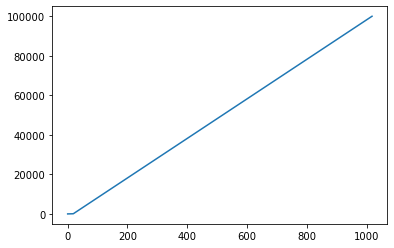

In [19]:
plt.plot(D['sample_no'][1])
plt.show()

In [40]:
D['ndata']

41

In [38]:
condmin = 0.002
condmax = 3.

np.linspace(np.log10(condmin), np.log10(condmax), 100)

array([-2.69897   , -2.66688827, -2.63480654, -2.60272481, -2.57064308,
       -2.53856135, -2.50647962, -2.4743979 , -2.44231617, -2.41023444,
       -2.37815271, -2.34607098, -2.31398925, -2.28190752, -2.24982579,
       -2.21774406, -2.18566233, -2.1535806 , -2.12149887, -2.08941714,
       -2.05733541, -2.02525368, -1.99317195, -1.96109022, -1.92900849,
       -1.89692676, -1.86484503, -1.8327633 , -1.80068157, -1.76859984,
       -1.73651811, -1.70443638, -1.67235465, -1.64027292, -1.60819119,
       -1.57610946, -1.54402773, -1.511946  , -1.47986427, -1.44778254,
       -1.41570081, -1.38361908, -1.35153735, -1.31945562, -1.28737389,
       -1.25529216, -1.22321043, -1.1911287 , -1.15904697, -1.12696524,
       -1.09488351, -1.06280178, -1.03072005, -0.99863832, -0.96655659,
       -0.93447486, -0.90239313, -0.8703114 , -0.83822967, -0.80614794,
       -0.77406621, -0.74198448, -0.70990275, -0.67782102, -0.64573929,
       -0.61365756, -0.58157583, -0.5494941 , -0.51741237, -0.48